In [1]:
import tensorflow as tf
tf.enable_eager_execution()

# Exploring Meta-dataset's TFRecords

In [2]:
RECORDS_DIR = "/Users/gomerudo/workspace/thesis_results/dtd"


In [3]:
# Import to list files in directories
import glob

tfrecords_list = sorted(glob.glob("{dir}/*.tfrecords".format(dir=RECORDS_DIR)))


In [4]:
tfrecord_data = tf.data.TFRecordDataset(tfrecords_list)
# o_classes = tfrecord_data.output_classes
# o_shapes = tfrecord_data.output_shapes
# o_types = tfrecord_data.output_types

# print(
#     "tfrecord_data | Type: {t} | Value: {v}".format(
#         t=type(tfrecord_data), v=tfrecord_data
#     )
# )
# print("Type of 'tfrecord_data' is: {t}".format(t=type(tfrecord_data)))


# print(
#     "  o_classes | Type: {t} | Value: {v}".format(
#         t=type(o_classes), v=str(o_classes)
#     )
# )

# print(
#     "  output_shapes | Type: {t} | Value: {v}".format(
#         t=type(o_shapes), v=str(o_shapes)
#     )
# )

# print(
#     "  o_types | Type: {t} | Value: {v}".format(
#         t=type(o_types), v=str(o_types)
#     )
# )




In [5]:
# # all_classes = set()
# summary = dict()
# # Iterate over all files
# for tf_record in tfrecords_list:
#     record_iterator = tf.python_io.tf_record_iterator(path=tf_record)
    
#     for string_record in record_iterator:
#         example = tf.train.Example()
#         example.ParseFromString(string_record)
#         print(example.features.feature.get("image").bytes_list.value[0])
#         break

In [6]:
# Create a description of the features.  
feature_description = {
    'image': tf.FixedLenFeature([], dtype=tf.string),
    'label': tf.FixedLenFeature([], tf.int64)
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.parse_single_example(example_proto, feature_description)

parsed_image_dataset = tfrecord_data.map(_parse_image_function)
parsed_image_dataset


<DatasetV1Adapter shapes: {image: (), label: ()}, types: {image: tf.string, label: tf.int64}>

23


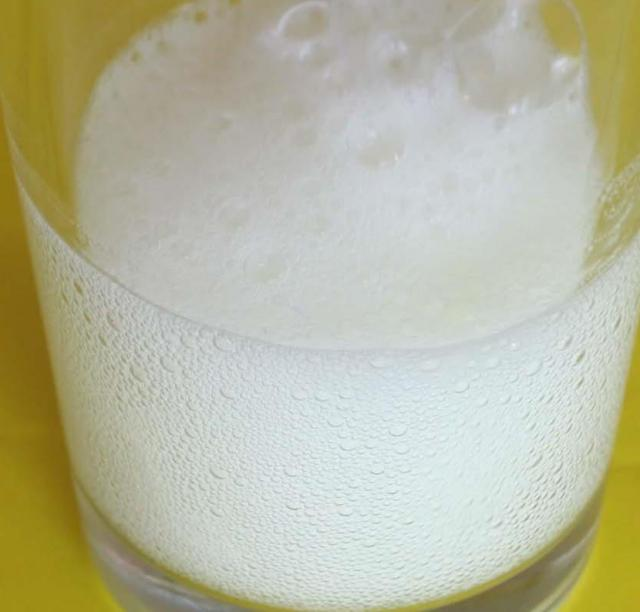

23


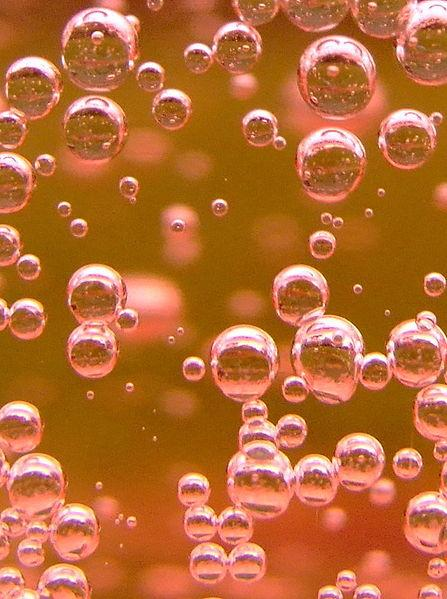

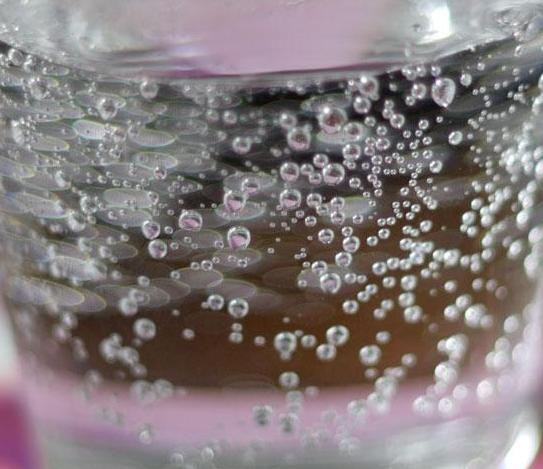

23
23


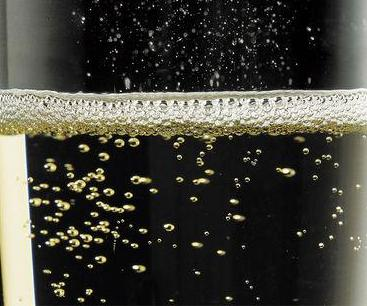

23


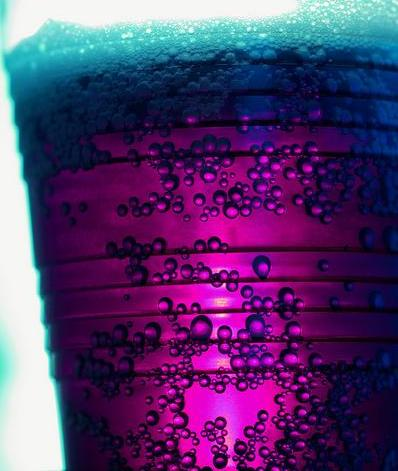

23


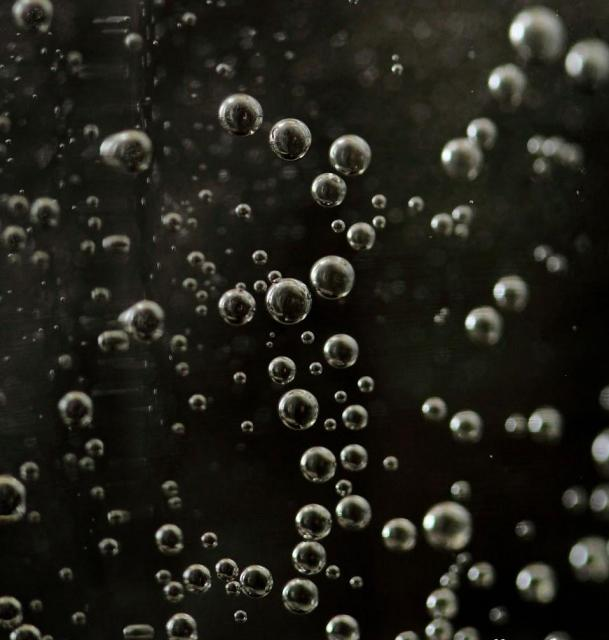

23


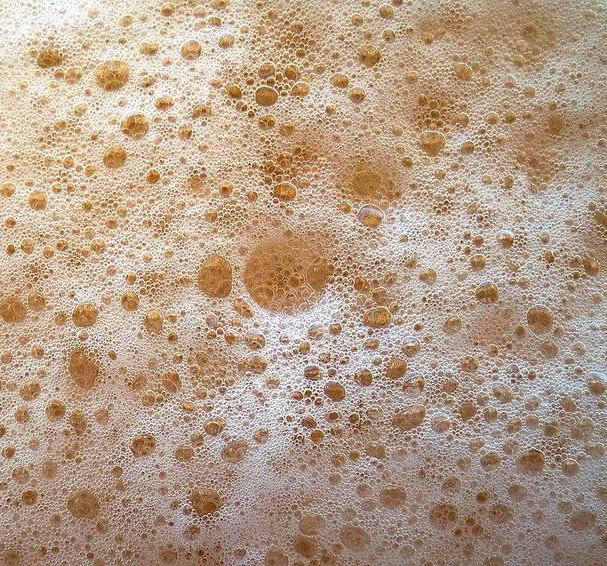

23


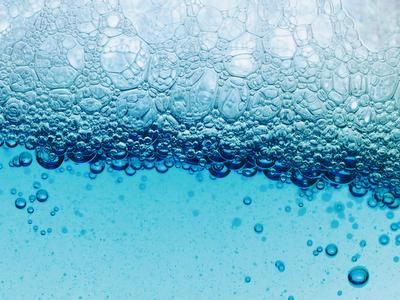

23


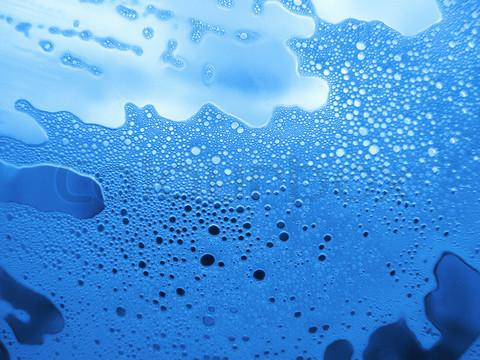

23


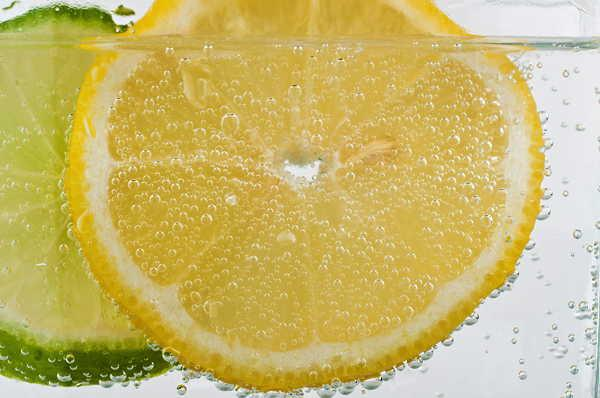

23


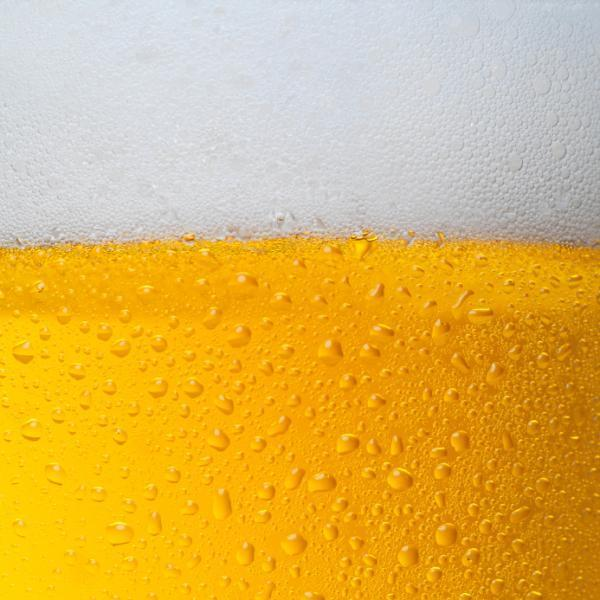

23


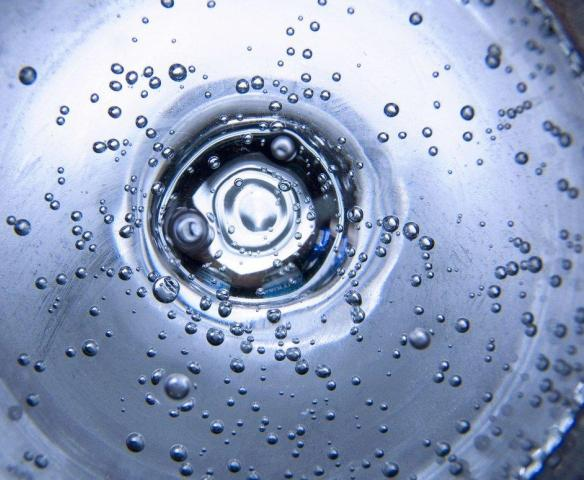

In [120]:
import IPython.display as display
import numpy as np
count = 0
COUNT_MAX = 10
count_pass = 0
COUNT_PASS_START = 2000
for image_features in parsed_image_dataset:
    count_pass += 1
    if count_pass < COUNT_PASS_START:
        continue
    image_raw = image_features['image'].numpy()
    arr = np.frombuffer(image_raw, dtype=np.uint8)
#     print(arr.shape[0])
    image = display.Image(data=image_raw)
#     print(image.retina)
    print(image_features['label'].numpy())
    display.display(image)
    if count > COUNT_MAX:
        break
    count += 1
    
    


## Playing with TensorFlow's TFRecords, Dataset and Estimator

In [16]:
image_size = 84

def n_elements(tfrecords_list):
    c = 0
    for fn in tfrecords_list:
        for record in tf.python_io.tf_record_iterator(fn):
            c += 1
    return c

def parser(record):
    # the 'features' here include your normal data feats along
    # with the label for that data
    features={
        'image': tf.FixedLenFeature([], dtype=tf.string),
        'label': tf.FixedLenFeature([], tf.int64)
    }

    parsed = tf.parse_single_example(record, features)

    # The image (features)
    image_decoded = tf.image.decode_jpeg(parsed['image'], channels=3)
    image_resized = tf.image.resize_images(
        image_decoded,
        [image_size, image_size],
        method=tf.image.ResizeMethod.BILINEAR,
        align_corners=True
    )
    image_normalized = image_resized / 255.0
    
    # The label
    label = tf.cast(parsed['label'], tf.int32)
    
    return {'x': image_normalized}, label

import math
import multiprocessing
def input_fn(tfrecord_data, length, batch_size=128, buffer=1024, is_train=True, split_prop=0.33):
    pattern = "{dir}/*.tfrecords".format(dir=tfrecord_data)
    trainset_length = math.floor(length*(1. - split_prop))
    
    files = tf.data.Dataset.list_files(pattern, shuffle=is_train, seed=32)
    threads = multiprocessing.cpu_count()
    
    dataset = files.apply(tf.contrib.data.parallel_interleave(
                lambda filename: tf.data.TFRecordDataset(filename), cycle_length=threads))

    if is_train:
        dataset = dataset.take(trainset_length)
        current_length = trainset_length
    else:
        dataset = dataset.skip(trainset_length)
        current_length = length - trainset_length

    
    # shuffle and repeat examples for better randomness and allow training beyond one epoch
    dataset = dataset.apply(tf.contrib.data.shuffle_and_repeat(current_length))

    # map the parse  function to each example individually in threads*2 parallel calls
    dataset = dataset.map(map_func=lambda example: parser(example),
                          num_parallel_calls=threads)

    # batch the examples
    dataset = dataset.batch(batch_size=batch_size)

    #prefetch batch
    dataset = dataset.prefetch(buffer_size=32)

    return dataset.make_one_shot_iterator().get_next()

#     # Length of the train-validation splits
#     trainset_length = math.floor(length*(1. - split_prop))
#     print("length", length)
#     print("trainset_length", trainset_length)    

#     dataset = tfrecord_data
    
#     dataset = dataset.shuffle(length, seed=32) 
    
#     if is_train:
#         dataset = dataset.take(trainset_length)
#     else:
#         dataset = dataset.skip(trainset_length)

#     dataset = dataset.map(parser)
#     dataset = dataset.shuffle(trainset_length)
#     dataset = dataset.repeat()
#     dataset = dataset.batch(batch_size)

#     # Length of the train-validation splits
#     trainset_length = math.floor(length*split_prop)
#     print("Length", length)
#     # Shuffle first to take the split
#     dataset = tfrecord_data
#     dataset = dataset.shuffle(length)

#     if is_train:
#         dataset = dataset.take(trainset_length)
#     else:
#         dataset = dataset.skip(trainset_length)
        
#     dataset = (
#         dataset
#         .map(parser)
#         .shuffle(trainset_length)
#         .batch(batch_size)
#     )
    
    return dataset
#     iterator = dataset.make_one_shot_iterator()
#     batch_feats, batch_labels = iterator.get_next()
#     return batch_feats, batch_labels
#     return iterator



In [122]:
# DNNClassifier = tf.estimator.DNNClassifier(
#     feature_columns = [
#         tf.feature_column.numeric_column(
#             key='x',
#             dtype=tf.float64,
#             shape=(84, 84, 3)
#         )
#     ],
#     hidden_units = [256, 256, 256, 256],
#     n_classes = 96,
#     model_dir = '/tmp/tf'
# )

# train_spec_dnn = tf.estimator.TrainSpec(
#     input_fn = lambda: input_fn(tfrecord_data, n_elements(tfrecords_list)),
#     max_steps=10
# )

# eval_spec_dnn = tf.estimator.EvalSpec(
#     input_fn = lambda: input_fn(tfrecord_data, n_elements(tfrecords_list))
# )

# # tf.estimator.train_and_evaluate(DNNClassifier, train_spec_dnn, eval_spec_dnn)

## Trying to visualize the output from the input_fn

In [76]:
# batch_feats, batch_labels = input_fn(tfrecord_data, n_elements(tfrecords_list))
iterator = input_fn(tfrecord_data, n_elements(tfrecords_list))

import pandas as pd

a = 0
df = pd.DataFrame()
for idx, element in enumerate(iterator):
    print("Processing batch", idx)
    
    a=idx
    img = element[0]['x'].numpy()
    print(img.shape)
    label = str(element[1])
    print(label)


    break
#     df = df.append([list(img.flatten()) + [label] ])

    if idx > 1:
        break

df.head()


length 5640
trainset_length 3778
Processing batch 0


KeyError: 0

(128, 84, 84, 3)
(84, 84, 3)


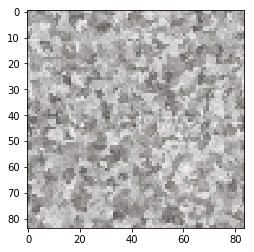

(84, 84, 3)


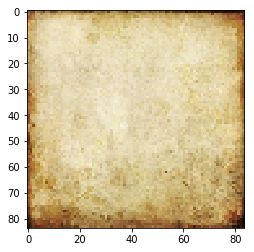

(84, 84, 3)


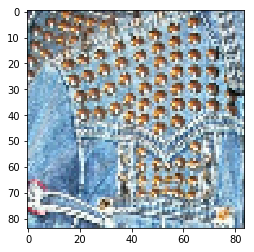

(84, 84, 3)


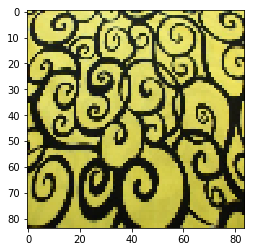

(84, 84, 3)


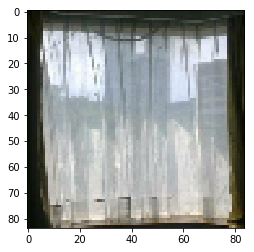

(84, 84, 3)


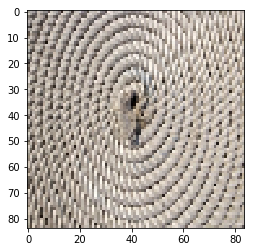

(84, 84, 3)


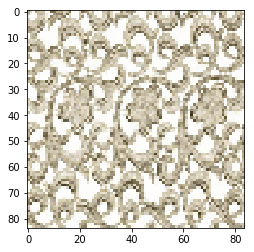

(84, 84, 3)


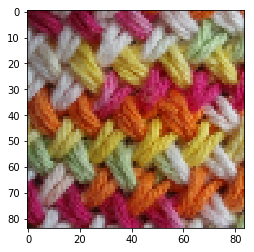

(84, 84, 3)


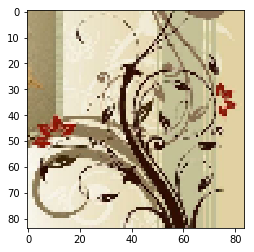

(84, 84, 3)


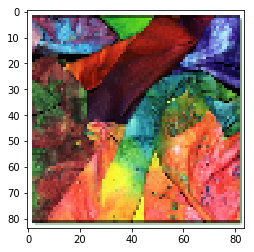

(84, 84, 3)


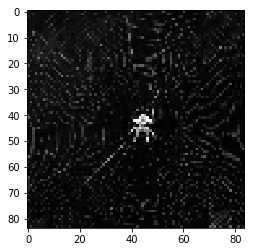

(84, 84, 3)


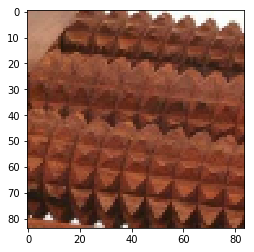

In [21]:
# batch_feats, batch_labels = input_fn(tfrecord_data, n_elements(tfrecords_list), is_train=True)
batch_feats, batch_labels = input_fn(RECORDS_DIR, n_elements(tfrecords_list), is_train=True)

eager_tensor = batch_feats['x']
print(eager_tensor.shape)
import matplotlib.pyplot as plt


# for element in batch_labels:
#     print(element)
#     print(element.shape)
# #     plt.imshow(element)
# #     plt.show()
# #     break

for element in eager_tensor.numpy()[:12,:,:,:]:
    print(element.shape)
    plt.imshow(element)
    plt.show()


In [132]:
dataset = input_fn(tfrecord_data, n_elements(tfrecords_list), is_train=True)

length 5640
trainset_length 3778


In [136]:
dataset

<DatasetV1Adapter shapes: ({x: (?, 84, 84, 3)}, (?,)), types: ({x: tf.float32}, tf.int32)>